In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm
import pywt
from datetime import datetime

In [3]:
#우선 교차검증 시 데이터 분할이 어떻게 이루어지는지 그려 볼 수 있게 해주는 helper function을 가져오자.
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [4]:
train_data = pd.read_csv("data/train_data.csv")
new_data = pd.read_csv("data/newdata.csv")


sample_submission = pd.read_csv("data/sample_submission.csv")

In [5]:
new_data=new_data[(new_data['Day']==201) | (new_data['Day']==202)]

In [6]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [7]:
new_data = new_data.fillna(method="ffill").fillna(method='bfill')
new_data.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

# 기타 전처리

In [8]:
df_updated = train_data.copy()

In [9]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [10]:
df['Tmstamp'][0].split(':')

['00', '00']

In [11]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [12]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))   

In [13]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))

In [14]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [15]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
#train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64


In [16]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [17]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [18]:
df = train_data.copy()

In [19]:
df = df.sort_values(by=['hour', 'Day', 'TurbID', 'minute'])
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [20]:
df = df.interpolate()
df = df.fillna(method='bfill')

In [21]:
df.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

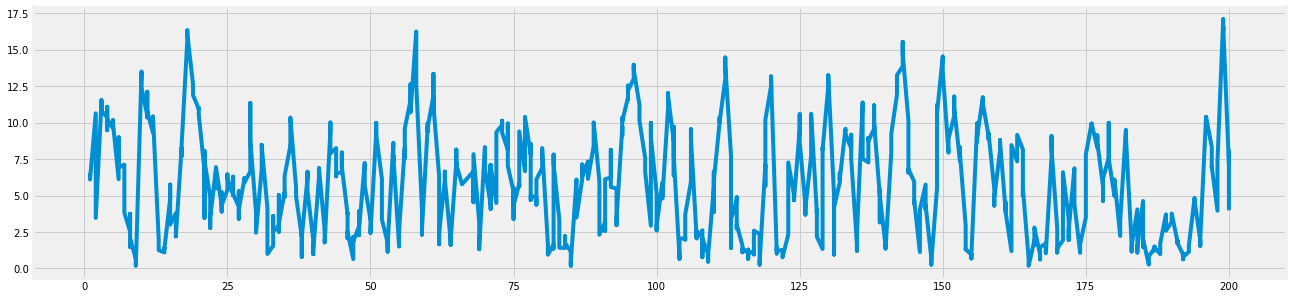

In [22]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 0 # hour
for i in range(1, 2): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['hour']==j)]['Day'], df[(df['TurbID']==i) & (df['hour']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [23]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [24]:
train_data = train_data.sort_values(by=['TurbID', 'Day', 'hour', 'minute'])
train_data.reset_index(drop=True, inplace=True)
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,140,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,141,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,142,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


----

In [25]:
# Y value 추가
train_data['Wspd_y']=train_data['Wspd']

In [26]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,6.27
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,6.42
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,6.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,139,23,1,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24,9.95
140,1,1,140,23,2,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74,12.20
141,1,1,141,23,3,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66,12.66
142,1,1,142,23,4,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64,12.58


In [27]:


x = np.array(train_data['Wspd'])
(ca, cd) = pywt.dwt(x, "haar")
cat = pywt.threshold(ca, np.std(ca), mode="soft")
cdt = pywt.threshold(cd, np.std(cd), mode="soft")
tx = pywt.idwt(cat, cdt, "haar")

In [28]:
train_data['Wspd']=tx

In [29]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,0,0,0,2.751439,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
1,1,1,1,0,1,2.751439,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
2,1,1,2,0,2,2.926439,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,6.27
3,1,1,3,0,3,2.926439,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,6.42
4,1,1,4,0,4,2.756439,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,6.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,139,23,1,1.576439,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,4.86
3859196,134,200,140,23,2,0.926439,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,4.46
3859197,134,200,141,23,3,0.926439,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,4.23
3859198,134,200,142,23,4,1.156439,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,4.36


In [133]:
# 1차분 변수 추가.
#train_data['Wspd_1']=0

#for turb in tqdm(range(1,135)):
#    train_data.loc[train_data['TurbID']==turb,'Wspd_1']=train_data.loc[train_data['TurbID']==turb,'Wspd']-train_data.loc[train_data['TurbID']==turb,'Wspd'].shift().fillna(method='bfill')




100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:01<00:00, 93.97it/s]


In [322]:
#pab 추가 변수

#train_data['Pab_over'] = 0

#train_data.loc[train_data['Pab1']>=89,'Pab_over'] = 1
#train_data.loc[train_data['Pab2']>=89,'Pab_over'] = 1
#train_data.loc[train_data['Pab3']>=89,'Pab_over'] = 1


In [107]:
train_data.describe()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
count,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06,3.859200e+06
mean,6.750000e+01,1.005000e+02,7.150000e+01,1.150000e+01,2.500000e+00,2.332244e+00,2.614239e-01,4.572761e+01,3.132578e+01,1.841302e+02,2.581436e+01,2.579058e+01,2.577532e+01,-1.489652e+01,3.586304e+02,5.232055e+00
std,3.868140e+01,5.773431e+01,4.156822e+01,6.922187e+00,1.707825e+00,2.937137e+00,2.987438e+01,8.394415e+01,1.716360e+01,1.671287e+02,3.813392e+01,3.812350e+01,3.811421e+01,7.072748e+01,4.249115e+02,3.446809e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.978181e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,0.000000e+00,0.000000e+00
25%,3.400000e+01,5.075000e+01,3.575000e+01,5.750000e+00,1.000000e+00,0.000000e+00,-3.810000e+00,2.069000e+01,2.611000e+01,5.112000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-4.070000e+01,0.000000e+00,2.440000e+00
50%,6.750000e+01,1.005000e+02,7.150000e+01,1.150000e+01,2.500000e+00,1.151439e+00,-2.400000e-01,2.829000e+01,3.279000e+01,1.909200e+02,6.500000e-01,6.500000e-01,6.495154e-01,-3.200000e-01,1.921600e+02,4.570000e+00
75%,1.010000e+02,1.502500e+02,1.072500e+02,1.725000e+01,4.000000e+00,3.836439e+00,3.350000e+00,3.389000e+01,3.819000e+01,3.211744e+02,7.687000e+01,7.650000e+01,7.629000e+01,-2.200000e-01,5.627400e+02,7.270000e+00
max,1.340000e+02,2.000000e+02,1.430000e+02,2.300000e+01,5.000000e+00,2.243106e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03,2.629000e+01


In [161]:
 # Y value 추가
#train_data=train_data[train_data['TurbID']==21]

In [162]:
# train_data = pd.read_csv("data/weighted_wspd_train.csv")

In [163]:
# train_data['Wspd2'] = train_data['Wspd_y']

# 데이터셋

In [164]:
#train_data['Wspd']=train_data['Wspd'].shift(+1).fillna(method="bfill")

In [165]:
# X 값들 수정해주기
#for dat in X_data:
#    dat[:,1]=np.log1p(dat[:,1])



In [30]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~174까지 train set으로 쓰는것. 
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            #day_list = [x for x in range(j, j+ 5)]
            day_list = [x for x in range(j, j+5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd_y"]
            
            # feature 선택 및 제거
            #train_tmp = train_tmp.drop(["TurbID", "Day","Patv","Etmp","Ndir"], axis = 1)
            train_tmp = train_tmp.drop(["TurbID","Day","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


def make_valid_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(185, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            #day_list = [x for x in range(j, j+ 5)]
            day_list = [x for x in range(j, j+5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd_y"]
            
            # feature 선택 및 제거
            #train_tmp = train_tmp.drop(["TurbID", "Day","Patv","Etmp","Ndir"], axis = 1)
            train_tmp = train_tmp.drop(["TurbID","Day","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


In [31]:
#train_data = train_data[train_data['TurbID']==21]

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
nor = MinMaxScaler()# 
y_nor = MinMaxScaler()

train_data[["Tmstamp","hour","minute",'Wspd',"Wdir","Etmp",'Itmp','Ndir',
            'Pab1','Pab2','Pab3',"Prtv",'Patv']] = nor.fit_transform(train_data[["Tmstamp","hour","minute",'Wspd',"Wdir","Etmp",'Itmp','Ndir',
            'Pab1','Pab2','Pab3',"Prtv",'Patv']])
train_data[["Wspd_y"]] = y_nor.fit_transform(train_data[["Wspd_y"]])

#["TurbID", "Day","Patv","Etmp","Ndir"]

In [33]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,0.000000,0.0,0.0,0.225494,0.571311,0.455167,0.527252,0.574451,0.100018,0.100018,0.100018,0.562729,0.315669,0.234690
1,1,1,0.006993,0.0,0.2,0.225494,0.571311,0.455167,0.527252,0.574451,0.100018,0.100018,0.100018,0.562729,0.315669,0.234690
2,1,1,0.013986,0.0,0.4,0.232381,0.571653,0.454972,0.526968,0.571291,0.100018,0.100018,0.100018,0.562738,0.325305,0.238494
3,1,1,0.020979,0.0,0.6,0.232381,0.571927,0.454852,0.526784,0.571291,0.100018,0.100018,0.100018,0.562720,0.346218,0.244199
4,1,1,0.027972,0.0,0.8,0.225690,0.572232,0.454807,0.526549,0.571291,0.100018,0.100018,0.100018,0.562747,0.325050,0.237733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,0.972028,1.0,0.2,0.179251,0.572948,0.422665,0.474689,0.668094,0.091017,0.091017,0.091017,0.465555,0.196966,0.184861
3859196,134,200,0.979021,1.0,0.4,0.153669,0.571309,0.422291,0.474572,0.671481,0.091017,0.091017,0.091017,0.478607,0.141415,0.169646
3859197,134,200,0.986014,1.0,0.6,0.153669,0.572049,0.422216,0.474388,0.666808,0.091017,0.091017,0.091017,0.462790,0.140777,0.160898
3859198,134,200,0.993007,1.0,0.8,0.162721,0.570909,0.422066,0.474187,0.666808,0.091017,0.091017,0.091017,0.465636,0.141766,0.165843


In [34]:
y_nor.scale_

array([0.03803728])

In [35]:
#실험
#nor.min_=nor.min_[0]
#nor.scale_=nor.scale_[0]

In [36]:
y_nor.inverse_transform(train_data[["Wspd_y"]])

array([[6.17],
       [6.17],
       [6.27],
       ...,
       [4.23],
       [4.36],
       [4.79]])

In [37]:
#tms_list = list(pd.unique(train_data["Tmstamp"]))

#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
#train_data["Tmstamp"] = train_data["Tmstamp"]//6

#hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


X_data, Y_data = make_train_data(train_data)
#valid_X_data, valid_Y_data = make_valid_data(train_data)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:21<00:00,  6.21it/s]


In [225]:
len(X_data)# 5일학습 기준 윈도우는 터빈당 194개. 194개 마다 hidden state 초기화 필요,

25996

In [226]:
pd.DataFrame(X_data[193])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.0,4.84,2.66,16.66,30.79,2.25,0.99,0.99,0.99,-0.30,318.77
1,1.0,0.0,1.0,4.72,-2.86,16.64,30.85,1.97,0.99,0.99,0.99,-0.27,280.18
2,2.0,0.0,2.0,4.76,-2.45,16.15,30.84,1.97,0.99,0.99,0.99,-0.27,302.37
3,3.0,0.0,3.0,4.72,-1.39,15.58,30.38,1.97,0.99,0.99,0.99,-0.28,307.44
4,4.0,0.0,4.0,4.63,-5.29,16.42,30.87,1.97,0.99,0.99,0.99,-0.28,284.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,139.0,23.0,1.0,15.52,0.75,12.84,29.67,11.22,1.16,1.16,1.16,-0.19,1373.97
716,140.0,23.0,2.0,15.83,-0.01,12.80,29.50,11.25,1.16,1.16,1.16,-0.22,1432.72
717,141.0,23.0,3.0,16.48,0.87,12.86,29.43,11.42,1.17,1.17,1.17,-0.24,1362.54
718,142.0,23.0,4.0,16.73,4.39,12.89,29.40,11.59,1.17,1.17,1.17,-0.22,1293.53


In [38]:
train_x  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1])
train_y = np.array(Y_data)


#valid_x  = np.array(valid_X_data).reshape(-1, valid_X_data[0].shape[0], valid_X_data[0].shape[1])
#train_x = np.array(X_data)
#valid_y = np.array(valid_Y_data)

print(train_x.shape, train_y.shape)
#print(valid_x.shape, valid_y.shape)

# 한터빈당 20개의 배치를 가진다.

(25996, 720, 13) (25996, 288)


In [48]:
from datetime import datetime
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
#출처: https://today-1.tistory.com/55 [Better Than,:티스토리]

In [14]:
# time stamp label encoding
#tms_list = list(pd.unique(train_data["Tmstamp"]))
#hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]

#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


# Fourier Features
#train_data['sin_24_1'] = np.sin(2 * np.pi * train_data['Tmstamp']/23.0)
#train_data['cos_24_1'] = np.cos(2 * np.pi * train_data['Tmstamp']/23.0)
#fourier_features(train_data['Tmstamp'], 24, 1)

#train_data.drop(['Tmstamp'],axis=1,inplace=True)

#X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


 database. History logging moved to new session 1439


TypeError: strptime() argument 1 must be str, not numpy.int64

In [39]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

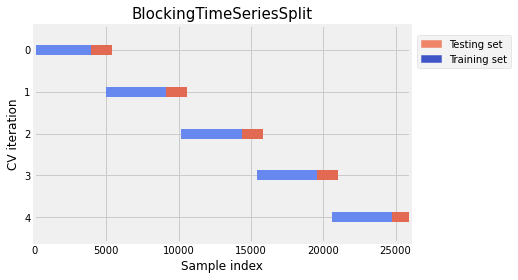

In [40]:
XX = np.arange(25996)
n_split = 5
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, XX, n_splits=n_split)

In [39]:
#train_y, valid_y, train_x, valid_x = temporal_train_test_split(X=X_data,y=Y_data, test_size=0.1 )
# 0.1 validation :117~121 , ...순서가 잘못됨.
# 0.05 validation :

In [41]:
for i, (train_index, test_index) in enumerate(btscv.split(train_x)):
    print("train : ",train_index)
    print("test : ",test_index)
    print("----")

train :  [   0    1    2 ... 4156 4157 4158]
test :  [4159 4160 4161 ... 5196 5197 5198]
----
train :  [5199 5200 5201 ... 9355 9356 9357]
test :  [ 9358  9359  9360 ... 10395 10396 10397]
----
train :  [10398 10399 10400 ... 14554 14555 14556]
test :  [14557 14558 14559 ... 15594 15595 15596]
----
train :  [15597 15598 15599 ... 19753 19754 19755]
test :  [19756 19757 19758 ... 20793 20794 20795]
----
train :  [20796 20797 20798 ... 24952 24953 24954]
test :  [24955 24956 24957 ... 25992 25993 25994]
----


In [42]:

x_fold_train = []
x_fold_valid = []

y_fold_train = []
y_fold_valid = []


for i, (train_index, test_index) in enumerate(btscv.split(train_x)):
    print("cv:", i+1, "TRAIN:", train_index, "/ TEST:", test_index)
    X_train, X_valid = train_x[train_index], train_x[test_index]
    y_train, y_valid = train_y[train_index], train_y[test_index]
    
    x_fold_train.append(X_train)
    x_fold_valid.append(X_valid)
    
    y_fold_train.append(y_train)
    y_fold_valid.append(y_valid)    
    

cv: 1 TRAIN: [   0    1    2 ... 4156 4157 4158] / TEST: [4159 4160 4161 ... 5196 5197 5198]
cv: 2 TRAIN: [5199 5200 5201 ... 9355 9356 9357] / TEST: [ 9358  9359  9360 ... 10395 10396 10397]
cv: 3 TRAIN: [10398 10399 10400 ... 14554 14555 14556] / TEST: [14557 14558 14559 ... 15594 15595 15596]
cv: 4 TRAIN: [15597 15598 15599 ... 19753 19754 19755] / TEST: [19756 19757 19758 ... 20793 20794 20795]
cv: 5 TRAIN: [20796 20797 20798 ... 24952 24953 24954] / TEST: [24955 24956 24957 ... 25992 25993 25994]


In [43]:
pd.DataFrame(x_fold_train[0][0])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.0,0.0,0.225494,0.571311,0.455167,0.527252,0.574451,0.100018,0.100018,0.100018,0.562729,0.315669
1,0.006993,0.0,0.2,0.225494,0.571311,0.455167,0.527252,0.574451,0.100018,0.100018,0.100018,0.562729,0.315669
2,0.013986,0.0,0.4,0.232381,0.571653,0.454972,0.526968,0.571291,0.100018,0.100018,0.100018,0.562738,0.325305
3,0.020979,0.0,0.6,0.232381,0.571927,0.454852,0.526784,0.571291,0.100018,0.100018,0.100018,0.562720,0.346218
4,0.027972,0.0,0.8,0.225690,0.572232,0.454807,0.526549,0.571291,0.100018,0.100018,0.100018,0.562747,0.325050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.972028,1.0,0.2,0.198338,0.571617,0.441741,0.515384,0.676060,0.099927,0.099927,0.099927,0.562720,0.302779
716,0.979021,1.0,0.4,0.224313,0.572351,0.441486,0.515434,0.674616,0.100018,0.100018,0.100018,0.562747,0.365222
717,0.986014,1.0,0.6,0.224313,0.571970,0.441276,0.514597,0.680683,0.099927,0.099927,0.099927,0.562720,0.326799
718,0.993007,1.0,0.8,0.191451,0.571847,0.441111,0.514045,0.679290,0.099927,0.099927,0.099927,0.562729,0.266078


In [44]:
pd.DataFrame(y_fold_train[0])

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,0.232788,0.265500,0.341955,0.323317,0.297452,0.263218,0.237353,0.284138,0.302016,0.273868,...,0.100038,0.080259,0.108406,0.130087,0.091289,0.098136,0.074933,0.071890,0.078357,0.106504
1,0.270825,0.176113,0.209585,0.192088,0.235070,0.145302,0.125903,0.136554,0.062762,0.123241,...,0.096234,0.080259,0.065424,0.068467,0.055154,0.042982,0.048688,0.044504,0.035755,0.028148
2,0.096234,0.142640,0.095093,0.055915,0.060860,0.077976,0.066946,0.058958,0.057436,0.072271,...,0.548117,0.503994,0.505896,0.472803,0.474325,0.465196,0.452644,0.533283,0.559909,0.554964
3,0.025485,0.028908,0.030810,0.025485,0.013313,0.006466,0.011031,0.025865,0.036896,0.041080,...,0.373526,0.367820,0.362876,0.373146,0.390643,0.367060,0.375428,0.389882,0.396348,0.406618
4,0.513884,0.492583,0.498669,0.512362,0.486877,0.471282,0.470521,0.490681,0.456447,0.427919,...,0.341575,0.355649,0.362876,0.374287,0.387980,0.392164,0.414987,0.411563,0.393686,0.374667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,0.222138,0.210346,0.196653,0.184100,0.153671,0.111449,0.106504,0.073792,0.055154,0.054774,...,0.246101,0.236592,0.243819,0.264739,0.289083,0.284899,0.259414,0.252568,0.278052,0.281095
4155,0.237733,0.237733,0.254469,0.238113,0.243439,0.236592,0.207303,0.210346,0.198555,0.183340,...,0.221757,0.231267,0.259414,0.263598,0.287562,0.296310,0.260175,0.257512,0.236211,0.267402
4156,0.257512,0.269304,0.264359,0.258273,0.247242,0.241156,0.244960,0.239635,0.201598,0.212628,...,0.365538,0.316090,0.265120,0.291366,0.276911,0.300875,0.292126,0.235070,0.202358,0.219475
4157,0.275390,0.305059,0.334348,0.325219,0.337010,0.313047,0.326740,0.379232,0.343477,0.420692,...,0.127045,0.102701,0.112210,0.153671,0.131989,0.114112,0.084062,0.109167,0.112590,0.127045


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

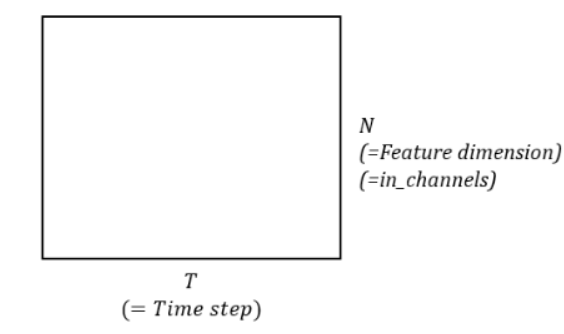

# 데이터 로더

In [45]:
EPOCHS = 30
BATCH_SIZE = 128
lr = 1e-3

In [46]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [47]:
train_dataset = TimeDataset(x_fold_train[0], y_fold_train[0])
valid_dataset = TimeDataset(x_fold_valid[0], y_fold_valid[0])


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [48]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([128, 720, 13]) type: torch.FloatTensor
Y_train :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


In [49]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([128, 720, 13]) type: torch.FloatTensor
Y_valid :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


In [50]:
def load_data(data_ind):
    train_dataset = TimeDataset(x_fold_train[data_ind], y_fold_train[data_ind])
    valid_dataset = TimeDataset(x_fold_valid[data_ind], y_fold_valid[data_ind])


    train_loader = DataLoader(train_dataset, 
                              batch_size = BATCH_SIZE,
                              shuffle=False)

    valid_loader = DataLoader(valid_dataset, 
                              batch_size = BATCH_SIZE,
                              shuffle=True)
    
    return train_loader,valid_loader



# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [93]:
lstm = nn.LSTM(input_size=12, hidden_size=256, batch_first=True, bidirectional=False)

lstm(X_valid)[0].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 7

In [106]:
lstm(X_valid)[0][-1].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [107]:
lstm(X_valid)[1][0]

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [29]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([128, 256])

In [70]:
c1 = nn.Conv1d(in_channels=720, out_channels=488, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
c2 = nn.Conv1d(in_channels=488, out_channels=256, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
pool1 = nn.MaxPool1d(kernel_size=3,stride=1)


o1 = c1(X_valid)
print(o1.size())
#o2 = pool1(o1)
#print(o1.size())

o2 = c2(o1)
print(o2.size())
o3 = pool1(o2)
print(o3.size())
#c1(X_valid).size()

torch.Size([128, 488, 6])
torch.Size([128, 256, 6])
torch.Size([128, 256, 4])


In [51]:
input_size=13


layer1_size = 720
layer2_size = 576
layer3_size = 432
layer4_size = 288
layer5_size = 144

layer6_size = 72

decoder_layer1_size = 144
decoder_layer2_size = 288
decoder_layer3_size = 432
decoder_layer4_size = 576
decoder_layer5_size = 720

In [52]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #인코더는 간단한 신경망으로 분류모델처럼 생겼습니다.
        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Linear(layer1_size*input_size, layer2_size*input_size), #차원을 28*28에서 점차 줄여나갑니다.
            nn.ReLU(),
            nn.Linear(layer2_size*input_size, layer3_size*input_size),
            nn.ReLU(),
            nn.Linear(layer3_size*input_size, layer4_size*input_size),
            nn.ReLU(),
            nn.Linear(layer4_size*input_size, layer5_size*input_size),
            nn.ReLU(),
            #히든 레이어
            nn.Linear(layer5_size*input_size, layer6_size*input_size),   # 입력의 특징을 압축합니다 (출력값이 바로 잠재변수가 됩니다.)
        )
        self.decoder = nn.Sequential(
            nn.Linear(layer6_size*input_size, decoder_layer1_size*input_size),
            nn.ReLU(),
            nn.Linear(decoder_layer1_size*input_size, decoder_layer2_size*input_size),
            nn.ReLU(),
            nn.Linear( decoder_layer2_size*input_size,  decoder_layer3_size*input_size),
            nn.ReLU(),
            nn.Linear(decoder_layer3_size*input_size,decoder_layer4_size*input_size),
            nn.ReLU(),
            nn.Linear(decoder_layer4_size*input_size,decoder_layer5_size*input_size),
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 잠재변수를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [53]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mse_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, label) in enumerate(train_loader):
        X = X.view(-1,X.size()[1]*X.size()[2]).to(DEVICE)
        Y = X
        
        optimizer.zero_grad()#데이터들 장비에 할당
        encoded,output = model(X) # model로 output을 계산
        #print(output.size(),Y.size())
        loss = criterion(output, Y)
        
        
        
        #loss = metric(output, Y)
        train_loss += loss.item()
        
        with torch.no_grad():
            
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
            
            mse = criterion(output,Y)
            train_mse_loss+=mse
            
        loss.backward()
        optimizer.step()
    
    #train_loss/=len(train_loader.dataset)
    #train_mae_loss/=len(train_loader.dataset)
    
    return train_mse_loss, train_mae_loss
    


In [54]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.view(-1,X.size()[1]*X.size()[2]).to(DEVICE)
            Y = X
            encoded,output = model(X) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            
            mae = metric(output, Y)
            valid_mae+=mae.item()
    #valid_loss/=len(valid_loader.dataset)
    #valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [ ]:
#학습 진행 코드


best_valid_mae_list = []
best_valid_loss_list = []
for data_ind in range(5):
    print("----- {} 차 교차검증 -----".format(data_ind+1))
    check_path = './checkpoint/checkpoint_baseline_ae'+str(data_ind+1)+'.pt'
    print(check_path)
    train_loader,valid_loader = load_data(data_ind)
    
    
    model = Autoencoder().to(DEVICE)
    criterion = nn.MSELoss().to(DEVICE)
    metric = nn.L1Loss().to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(),lr=lr)


    
    best_valid_mae = 999999
    best_valid_loss = 9999999999
    
    early_stopcount = 0

    for Epoch in range(1,EPOCHS+1):
        train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_mae = evaluate(model, valid_loader)
        
        
        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                      format(Epoch, train_loss, train_mae,
                             valid_loss, valid_mae))
        
        
        
        #if best_valid_mae > valid_mae:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_mae,valid_mae ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss = valid_loss
    best_valid_mae_list.append(best_valid_mae)
    best_valid_loss_list.append(best_valid_loss)
    print("종료.")
        
    
    

----- 1 차 교차검증 -----
./checkpoint/checkpoint_baseline_ae1.pt

[EPOCH:1]	 Train Loss:34.9232	 Train MAE:17.2880  | 	Valid Loss:0.6852 	Valid MAE: 2.2487

-- SAVE Checkpoint --
Valid loss : 999999.0000 -> 2.2487 


[EPOCH:2]	 Train Loss:1.2611	 Train MAE:4.1526  | 	Valid Loss:0.4030 	Valid MAE: 1.1985

-- SAVE Checkpoint --
Valid loss : 2.2487 -> 1.1985 


[EPOCH:3]	 Train Loss:1.1708	 Train MAE:3.6943  | 	Valid Loss:0.3976 	Valid MAE: 1.2041

-- SAVE Checkpoint --
Valid loss : 1.1985 -> 1.2041 


[EPOCH:4]	 Train Loss:1.1700	 Train MAE:3.6715  | 	Valid Loss:0.4013 	Valid MAE: 1.2088

-- SAVE Checkpoint --
Valid loss : 1.2041 -> 1.2088 


[EPOCH:5]	 Train Loss:1.1700	 Train MAE:3.6683  | 	Valid Loss:0.4000 	Valid MAE: 1.2066

-- SAVE Checkpoint --
Valid loss : 1.2088 -> 1.2066 


[EPOCH:6]	 Train Loss:1.1706	 Train MAE:3.6515  | 	Valid Loss:0.3981 	Valid MAE: 1.1963

-- SAVE Checkpoint --
Valid loss : 1.2066 -> 1.1963 


[EPOCH:7]	 Train Loss:1.1694	 Train MAE:3.6479  | 	Valid Loss:0.394

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\USER\AppData\Local\Temp/ipykernel_14744/1028094117.py", line 40, in <module>
    torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\serialization.py", line 381, in save
    _legacy_save(obj, opened_file, pickle_module, pickle_protocol)
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\serialization.py", line 454, in _legacy_save
    serialized_storages[key]._write_file(f, _should_read_directly(f), True)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 2077, 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\USER\AppData\Local\Temp/ipykernel_14744/1028094117.py", line 40, in <module>
    torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\serialization.py", line 381, in save
    _legacy_save(obj, opened_file, pickle_module, pickle_protocol)
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\serialization.py", line 454, in _legacy_save
    serialized_storages[key]._write_file(f, _should_read_directly(f), True)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 2077, 

In [106]:
ddddd

[]

# validation 확인

In [67]:
best_valid_loss_list

[57.89325571060181,
 61.93735074996948,
 33.839824199676514,
 24.66572403907776,
 34.788039207458496]

In [115]:
for i in range(5):
    print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss_list[i],best_valid_mae_list[i]))

Valid loss : 87.8011 / Valid MAE : 20.3817 



IndexError: list index out of range

In [164]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.0589 / Valid MAE : 0.6580 



In [266]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

# lstm baseline : Valid loss : 0.3510 / Valid MAE : 2.1029 

Valid loss : 0.0554 / Valid MAE : 0.6800 



# TEST

In [156]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]
#test_data = test_data[test_data['TurbID']==21]
#전처리했다면, X_data로 불러와야함.


test_data = test_data.drop(["TurbID","Day","Wspd_y"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [157]:
test_data.shape

(134, 720, 14)

In [158]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [159]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [160]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline3.pt')
model.load_state_dict(best_checkpoint)
model.eval()

BaseModel(
  (lstm): LSTM(14, 512, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=288, bias=True)
    (3): ReLU()
  )
)

In [93]:
model.lstm

LSTM(14, 512, batch_first=True)

In [94]:
preds = predict(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.30it/s]


In [95]:
y_nor.scale_

AttributeError: 'MinMaxScaler' object has no attribute 'scale_'

In [96]:
#preds = y_nor.inverse_transform(preds)
preds = preds.reshape(-1)

In [97]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [98]:
sample_submission['Wspd']=preds

In [99]:
#for i in range(1,135):
#    sample_submission.loc[sample_submission["TurbID"]==i,"Wspd"] = preds

In [100]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,0.975638,0,0,0,0,0,0,0,0,9999
1,1,1,201,00:10,0.829450,0,0,0,0,0,0,0,0,9999
2,2,1,201,00:20,0.656395,0,0,0,0,0,0,0,0,9999
3,3,1,201,00:30,0.623910,0,0,0,0,0,0,0,0,9999
4,4,1,201,00:40,0.777110,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,0.000000,0,0,0,0,0,0,0,0,9999
38588,38588,134,202,23:20,0.000000,0,0,0,0,0,0,0,0,9999
38589,38589,134,202,23:30,0.000000,0,0,0,0,0,0,0,0,9999
38590,38590,134,202,23:40,0.000000,0,0,0,0,0,0,0,0,9999


In [101]:

sample_submission.to_csv("./submit.csv", index = False)

(0.0, 20.0)

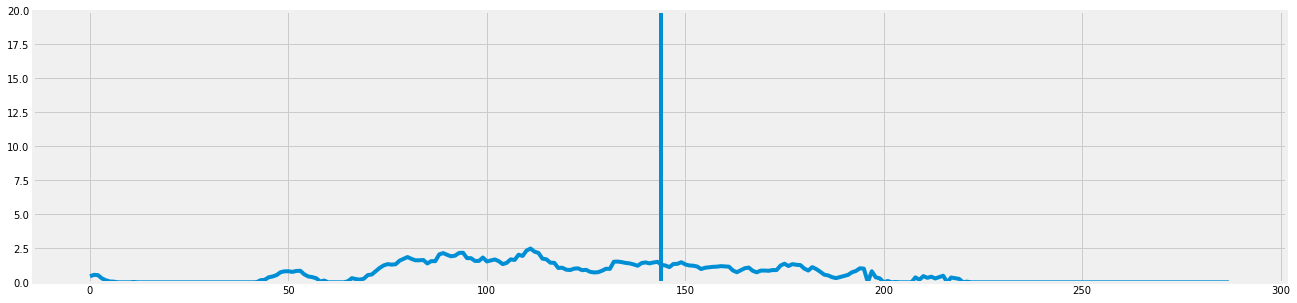

In [102]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(0,288),sample_submission.loc[sample_submission["TurbID"]==130,"Wspd"])
plt.vlines(144,0,20)
plt.ylim([0,20])

ValueError: x and y must have same first dimension, but have shapes (288,) and (0,)

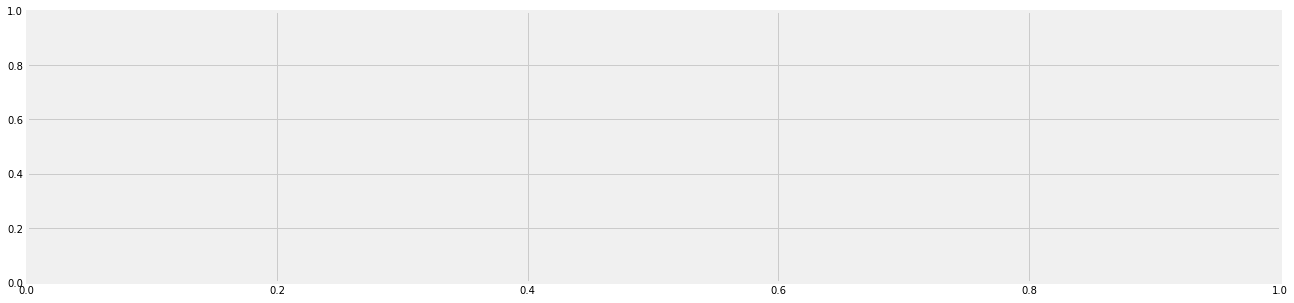

In [80]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(0,288),train_data.loc[ ((train_data["Day"]==105)|(train_data["Day"]==106
                                                                    )) &(train_data["TurbID"]==1) ,"Wspd"])
plt.vlines(144,0,1)
plt.ylim([0,1])